(dl/07-attention)=
# Attention and Transformers

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/dl/07-attention.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

**Readings:**  [[1]](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html), [[2]](https://www.d2l.ai/chapter_attention-mechanisms-and-transformers/index.html), [[3]](https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3), {cite}`transformers`

## Introduction

- introduce attention mechanism and build intuition
- handle sequence of arbitrary length

In [1]:
import math
import torch
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.notebook import tqdm
from matplotlib_inline import backend_inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 42
DEBUG = False
MATPLOTLIB_FORMAT = "png" if DEBUG else "svg"

pl.seed_everything(RANDOM_SEED)
warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats(MATPLOTLIB_FORMAT)
print("device:", DEVICE)

Global seed set to 42


device: mps


## Attention mechanism

An **attention mechanism** involves averaging state or **value** vectors of input elements dynamically based on a soft lookup with respect to the corresponding **keys** of each element given an input **query**. The values are combined using a convex combination $\sum_{j} \alpha_j \boldsymbol{\mathsf{v}}_j$ as output of the layer where $\sum_j\alpha_j = 1.$ The weights $\alpha_j$ are typically obtained using the softmax:

$$
\alpha_j=\frac{\exp \left(f_{\text {attn}}\left(\boldsymbol{\mathsf{q}}, \boldsymbol{\mathsf{k}}_j\right)\right)}{\sum_k \exp \left(f_{\text {attn}}\left(\boldsymbol{\mathsf{q}}, \boldsymbol{\mathsf{k}}_k\right)\right)}, \quad \text {out}=\sum_j \alpha_j \boldsymbol{\mathsf{v}}_j
$$

where $f_{\text {attn }}$ is called the **score function**. The vectors $\boldsymbol{\mathsf{k}}_i, \boldsymbol{\mathsf{v}}_i$ for $i = 1, \ldots, T$ are obtained from a sequence of inputs $(\boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_T)$ and the query vector $\boldsymbol{\mathsf{q}}$ from a test input $\boldsymbol{\mathsf{y}}.$ The functions for transforming inputs to keys, queries, and values are generally parametric and are learned during the course of training. This scoring part sort of implements [kernel similarity](https://en.wikipedia.org/wiki/Kernel_method) where we score the similarity of vectors in the representation space (see [this answer](https://stats.stackexchange.com/a/463320/313872) in SE).

```{figure} ../../img/nn/07-qkv.svg
---
name: 07-qkv
width: 500px
---
Soft lookup by pooling value vectors using attention weights. [Source](https://www.d2l.ai/chapter_attention-mechanisms-and-transformers/queries-keys-values.html)
```

**Q and K.** The query is a feature vector which can be interpreted as what the input is "looking for". 
The keys are learned to maximize $f_{\text {attn }}$ with an appropriate query.
It roughly describes what an input $\boldsymbol{\mathsf{x}}_i$ is "offering", or when it might be important. The score function $f_{\text {attn }}$ which evaluates the key-query pair is usually implemented by simple similarity metrics like a dot product or a small MLP. Note that the roles of queries and keys are inherently asymmetric, hence since the scoring function is usually defined as a symmetric operation, the transformations from input to query and key vectors are defined separately. 

**Values.** The value vectors are task-specific and designed for downstream processing. 
The resulting weighted average reflects what the query vector is paying attention to in the sequence.
For example, in language modeling, the value vectors can be thought of as modified embeddings 
which help with resolving ambiguity in the original embeddings by combining the context (with convex weights) given a query.

**Attention as soft lookup.** Observe that the attention mechanism is similar to a kernel KNN. But instead of returning the label of the most similar training vector, it outputs a weighted label based on its similarity scores. In other words, instead of a hard lookup in $\{(\boldsymbol{\mathsf{k}}_1, \boldsymbol{\mathsf{v}}_1), \ldots, (\boldsymbol{\mathsf{k}}_T, \boldsymbol{\mathsf{v}}_T)\}$, a test data performs a **soft lookup** operation with the keys. This can be seen in the following example:

In [2]:
def gaussian(d, sigma):
    return torch.exp(-d ** 2 / (2 * sigma ** 2))

def kernel(q, k, sigma):
    """K[i, j] = G(q_i, k_j)"""
    d = q.view(-1, 1) - k.view(1, -1)
    return gaussian(d, sigma)

def f(x):
    return 2 * torch.sin(x) + x

# Toy dataset
n = 120
x_train, _ = torch.sort(torch.rand(n) * 10)
y_train = f(x_train) + torch.randn(n)   # signal + noise
x = torch.arange(0, 10, 0.1)
y = f(x)

Here the values are scalars and the keys and queries are identical for each instance:

In [3]:
def attention_pooling(x_train, y_train, x, sigma=1.0):
    """Nadaraya-Watson regression (1964)."""
    k = kernel(x, x_train, sigma=sigma)
    attn_weights = k / k.sum(0)     # linear: kernel already has exps
    y_hat = attn_weights @ y_train
    return y_hat, attn_weights

Plotting the values and attention weights (kernel scores):

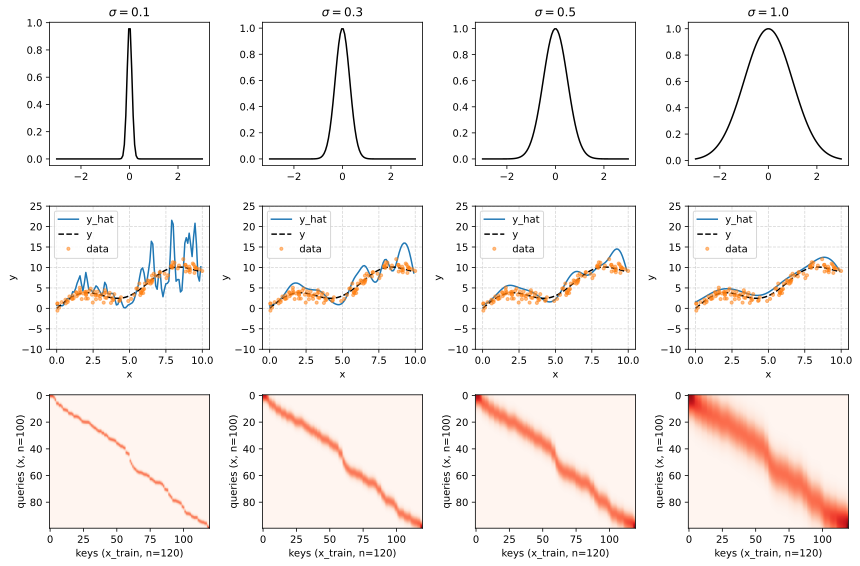

In [4]:
fig, ax = plt.subplots(3, 4, figsize=(12, 8))

for i, sigma in enumerate([0.1, 0.3, 0.5, 1.0]):
    y_hat, attn_weights = attention_pooling(x_train, y_train, x, sigma=sigma)
    t = torch.linspace(-3, 3, 100)
    ax[0, i].plot(t, gaussian(t, sigma), color="k")
    ax[0, i].set_title(r"$\sigma =$" + f"{sigma:.1f}")
    ax[1, i].plot(x, y_hat, label="y_hat")
    ax[1, i].plot(x, y, 'k--', label="y")
    ax[1, i].plot(x_train, y_train, 'o', markersize=3.1, alpha=0.5, label="data")
    ax[1, i].set_xlabel("x")
    ax[1, i].set_ylabel("y")
    ax[1, i].set_ylim(-10, 25)
    ax[1, i].legend()
    ax[1, i].grid(linestyle="dashed", alpha=0.5)
    ax[2, i].imshow(attn_weights.detach().numpy(), cmap='Reds')
    ax[2, i].set_ylabel(f"queries (x, n={len(x)})")
    ax[2, i].set_xlabel(f"keys (x_train, n={len(x_train)})");

fig.tight_layout()

**Figure.** Gaussian kernel width is controlled by the $\sigma$ parameter. The narrower the kernel, the less smooth the estimate becomes. At the same time, it adapts better to local variations. In the context of attention, the width of the kernel essentially increases or decreases the points in the dataset that a test query "attends" to as shown in the attention weights plot.

## Scaled dot product attention

Attention mechanisms differ in terms of what queries they use, how the key and value vectors are defined, and what score function is used. In this section,
we describe the **scaled dot product attention** (SDPA). The goal of this attention mechanism is that any element in a sequence can attend to unmasked elements of the other sequence while still being efficient to compute:

$$
\operatorname{Attention}(\boldsymbol{\mathsf{Q}}, \boldsymbol{\mathsf{K}}, \boldsymbol{\mathsf{V}})
=\operatorname{Softmax}\left(\frac{\boldsymbol{\mathsf{Q}} \boldsymbol{\mathsf{K}^\top}}{\sqrt{d}} + \boldsymbol{\mathsf{M}}\right) \boldsymbol{\mathsf{V}}.
$$

Here $\boldsymbol{\mathsf{Q}}$ and $\boldsymbol{\mathsf{K}}$ are 
$T_q \times d$ and $T_k \times d$ matrices, respectively,
with rows consisting of query vectors $(\boldsymbol{\mathsf{q}}_1, \ldots, \boldsymbol{\mathsf{q}}_{T_q})$ and key vectors $(\boldsymbol{\mathsf{k}}_1, \ldots, \boldsymbol{\mathsf{k}}_{T_k}).$ The value matrix $\boldsymbol{\mathsf{V}}$ is $T_k \times d_v$ and contains rows of value vectors $(\boldsymbol{\mathsf{v}}_1, \ldots, \boldsymbol{\mathsf{v}}_{T_k})$ corresponding to the keys.
The matrix
$\boldsymbol{\mathsf{M}}$, called the **attention mask**, is $T_q \times T_k$ with entries either $0$ or $-\infty$. The factor $\sqrt{d}$ is there so that variance ~ 1. 
The final output is then $T_q \times d_v$  which corresponds to one value vector per query. 
Note that the batch dimension is supressed for simplicity. Observe that computation is efficient regardless of context sizes $T_q$ and $T_k$ since it involves only matrix operations. 

**Masking.** Note that the attention weights has shape $T_q \times T_k$ which corresponds to communication between any two query-key pair. 
Since $\exp(-\infty) = 0$, this means that the weights are computed over the unmasked attention scores. 
Hence, an attention mask nullifies any communication between two pairs of inputs. For example, in **causal attention**, $\boldsymbol{\mathsf{M}}_{ij} = -\infty$ precisely when $j > i$ so that a query cannot look at future keys in the sequence.
In our implementation, we use indicators to mask attention scores instead of adding a tensor `M`:

In [5]:
T = 3
mask = torch.tril(torch.ones(T, T))  # causal
attn_score = torch.randn(3, 3)
print("Mask (indicators)\n", mask, "\n")
print("Attention scores\n", attn_score, "\n")
print("Masked attention scores\n", attn_score.masked_fill(mask == 0, -torch.inf))

Mask (indicators)
 tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]]) 

Attention scores
 tensor([[ 0.0110,  0.1447,  1.2818],
        [-1.5952, -1.0648,  0.1055],
        [ 1.9739,  1.0703, -1.7379]]) 

Masked attention scores
 tensor([[ 0.0110,    -inf,    -inf],
        [-1.5952, -1.0648,    -inf],
        [ 1.9739,  1.0703, -1.7379]])


In [6]:
pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

PyTorch implementation of SDPA:

In [7]:
def scaled_dot_product(q, k, v, mask=None):
    d = q.shape[-1]
    attn_score = torch.einsum("ik, jk -> ij", q, k)
    attn_score = attn_score / math.sqrt(d)
    if mask is not None:
        assert mask.shape == attn_score.shape
        attn_score = attn_score.masked_fill(mask == 0, -torch.inf)
    
    attention = F.softmax(attn_score, dim=-1)
    values = torch.einsum("ik, kj -> ij", attention, v)
    return values, attention

Example computation of causal attention:

In [8]:
T, d, v = 3, 2, 4
q = torch.randn(T, d)
k = torch.randn(T, d)
v = torch.randn(T, v)
output, attention = scaled_dot_product(q, k, v, mask)

print("Q\n", q, "\n")
print("K\n", k, "\n")
print("V\n", v, "\n")
print("Attention\n", attention, "\n")
print("Output\n", output, "\n")

Q
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]]) 

K
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]]) 

V
 tensor([[ 1.1103, -1.6898, -0.9890,  0.9580],
        [ 1.3221,  0.8172, -0.7658, -0.7506],
        [ 1.3525,  0.6863, -0.3278,  0.7950]]) 

Attention
 tensor([[1.0000, 0.0000, 0.0000],
        [0.5355, 0.4645, 0.0000],
        [0.1303, 0.4630, 0.4067]]) 

Output
 tensor([[ 1.1103, -1.6898, -0.9890,  0.9580],
        [ 1.2087, -0.5252, -0.8853,  0.1643],
        [ 1.3069,  0.4372, -0.6168,  0.1007]]) 



The output vectors are obtained as convex combination of attention weights and value vectors:

In [9]:
0.1303 * v[0] + 0.4630 * v[1] + 0.4067 * v[2]

tensor([ 1.3069,  0.4373, -0.6167,  0.1006])

The first vector only attends to itself, so the value vector is unchanged.

<br>

**Remark.** PyTorch has an [efficient implementation](https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html) of SDPA similar to what we have above:

In [10]:
# WARNING: Expects boolean mask! if float, additive implementation, i.e. +M
F.scaled_dot_product_attention(q, k, v, mask.bool())

tensor([[ 1.1103, -1.6898, -0.9890,  0.9580],
        [ 1.2087, -0.5252, -0.8853,  0.1643],
        [ 1.3069,  0.4372, -0.6168,  0.1007]])

This is so much faster and more stable compared to our implementation:

In [11]:
%%timeit -n 1000
# einsum is slow (see https://github.com/pytorch/pytorch/issues/32591)
# but F.scaled_dot_product_attention still beats permute and @ by 20% relative
scaled_dot_product(q, k, v, mask)

30.3 µs ± 2.31 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [12]:
%%timeit -n 1000
F.scaled_dot_product_attention(q, k, v, mask.bool())

10.2 µs ± 180 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Multi-head attention (MHA)

Given the same set of queries, keys, and values we may want our model to combine knowledge from different behaviors of the same attention mechanism, such as capturing dependencies of various ranges (shorter range vs. longer range, or different word senses). 
Hence, we extend the attention mechanism to have **multiple heads**, i.e. $(\boldsymbol{\mathsf{Q}}_i, \boldsymbol{\mathsf{K}}_i, \boldsymbol{\mathsf{V}}_i)$ triples for $i = 1, \ldots, H$, on the same inputs. 
This is similar to convolutions where we learn multiple feature detectors in parallel. We will assume $d = d_v = d_\text{model}.$ Let $\boldsymbol{\mathsf{Q}} \in \mathbb{R}^{T_q \times d_\text{model}}$ and $\boldsymbol{\mathsf{K}}, \boldsymbol{\mathsf{V}} \in \mathbb{R}^{T_k \times d_{\text{model}}}$, then:

$$\begin{aligned}
\operatorname{MultiheadAttention}(\boldsymbol{\mathsf{Q}}, \boldsymbol{\mathsf{K}}, \boldsymbol{\mathsf{V}})
&= \bigoplus_{i=1}^H\left[\text{Attention}(\boldsymbol{\mathsf{Q}} \boldsymbol{\mathsf{W}}_i^\mathsf{Q}, \boldsymbol{\mathsf{K}} \boldsymbol{\mathsf{W}}_i^\mathsf{K}, \boldsymbol{\mathsf{V}} \boldsymbol{\mathsf{W}}_i^\mathsf{V})\right]\, {\boldsymbol{\mathsf{W}}^{\mathsf{O}\top}} \\
&\in \mathbb{R}^{T_q \times d_\text{model}}
\end{aligned}$$

where $\boldsymbol{\mathsf{W}}^\mathsf{O} \in \mathbb{R}^{d_{\text{model}} \times d_{\text{model}}}.$ Note that the number of heads $H$ must divide $d_\text{model}.$ The biases are usually not included as we do here. The idea is that $\boldsymbol{\mathsf{W}}_i^\mathsf{Q} \in \mathbb{R}^{d_{\text{model}} \times d_h}$ projects the queries $\boldsymbol{\mathsf{Q}}$ onto a lower dimensional subspace of dimension $d_h = d_{\text{model}} / H$, and similarly for keys and values. 
Finally, the lower dimensional output heads $\boldsymbol{\mathsf{h}}_i$ are mixed together at the end as 
$\boldsymbol{\mathsf{o}}^j = \sum_{i=1}^H \boldsymbol{\mathsf{h}}_i \cdot \boldsymbol{\mathsf{w}}_i^j$
for $j = 1, \ldots, d_\text{model}$
where $\bigoplus_{i=1}^H \boldsymbol{\mathsf{w}}_i^j$ is the $j$-th row of $\boldsymbol{\mathsf{W}}^\mathsf{O}.$
Multi-head attention therefore combines knowledge of the same attention pooling via different representation subspaces of queries, keys, and values. The architecture is depicted in {numref}`07-mha`.

**Remark.** To facilitate residuals, all sub-layers in the model, including the embedding
layers, produce outputs of dimension $d_\text{model}$ following {cite}`transformers`. Also, note that the queries $\boldsymbol{\mathsf{Q}}$ are projected to $\boldsymbol{\mathsf{Q}}_i = \boldsymbol{\mathsf{Q}}\boldsymbol{\mathsf{W}}_i^\mathsf{Q}.$ Hence, it suffices to learn a single fused matrix $\boldsymbol{\mathsf{W}}^\mathsf{Q}$ where we calculate $\boldsymbol{\mathsf{Q}}_i$ as an $h$-sized slice of $\hat{\boldsymbol{\mathsf{Q}}} = \boldsymbol{\mathsf{Q}}\boldsymbol{\mathsf{W}}^\mathsf{Q}.$ Similarly we learn weights to calculate $\hat{\boldsymbol{\mathsf{K}}} = \boldsymbol{\mathsf{K}}\boldsymbol{\mathsf{W}}^\mathsf{K}$ and $\hat{\boldsymbol{\mathsf{V}}} = \boldsymbol{\mathsf{V}}\boldsymbol{\mathsf{W}}^\mathsf{V}$ for the keys and queries. This is what we will do in the implementation below, where we calculate MHA in parallel in a single pass after carefully indexing the $\hat{\boldsymbol{\mathsf{Q}}}, \hat{\boldsymbol{\mathsf{K}}}, \hat{\boldsymbol{\mathsf{V}}}$ tensors.

**Self-attention.** Let $\boldsymbol{\mathsf{X}} = (\boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_{T}).$ The important case where $\boldsymbol{\mathsf{Q}}, \boldsymbol{\mathsf{K}}, \boldsymbol{\mathsf{V}} = \boldsymbol{\mathsf{X}}$ is called **self-attention**. Here any sequence element attends to itself. The attention score has shape $T \times T$ since $T = T_q = T_k.$ This can be masked depending on the implementation, e.g. to prevent data leakage. 
For example, in **causal self-attention**, the mask has $\boldsymbol{\mathsf{M}}_{ij} = -\infty$ precisely when $j > i$ so that a query cannot look at future keys in the same sequence.
Finally, the computation is asymmetric, the score $\boldsymbol{\mathsf{q}} \cdot \boldsymbol{\mathsf{k}}$ for the same input vector $\boldsymbol{\mathsf{x}}$ need not be 1 (i.e. $\boldsymbol{\mathsf{x}}$ is not looking for itself) since the embedding vectors $\boldsymbol{\mathsf{X}}$ are projected using different transformations.

```{figure} ../../img/nn/07-mha.png
---
name: 07-mha
width: 300px
---
Multi-head attention. Source: {cite}`transformers`
```

In [13]:
class MultiheadAttention(nn.Module):
    
    def __init__(self, d_model: int, num_heads: int):
        super().__init__()
        assert d_model % num_heads == 0, "No. of heads divides d_model."
        self.d_model = d_model
        self.n_heads = num_heads
        self.d_head = d_model // num_heads

        # Stack all weight matrices 1...H together for efficiency
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.w_o = nn.Linear(d_model, d_model, bias=False)

    def forward(self, query, key, value, mask=None, return_attention=False):
        """
        Queries, keys, and values are expected to have shapes (B, T, d_model).
        Two types of masks are supported. A boolean mask where a value of True 
        indicates that the element should take part in attention. A float mask 
        of same type as query, key, value that is added to the attention score.
        """
        if mask is not None:
            mask = self.expand_mask(mask)

        # Project onto subspaces
        q = self.w_q(query)     # (B, Tq, d_model) -> (B, Tq, d_model)
        k = self.w_k(key)       # (B, Tk, d_model) -> (B, Tk, d_model)
        v = self.w_v(value)     # (B, Tk, d_model) -> (B, Tk, d_model)

        # Decompose: (B, T, d_model) -> (B, T, H, d_head) -> (B, H, T, d_head)
        assert q.shape[0] == k.shape[0] == v.shape[0]
        assert k.shape[1] == v.shape[1]
        B  = q.shape[0]
        Tq = q.shape[1]
        Tk = k.shape[1]
        q = q.view(B, Tq, self.n_heads, self.d_head).transpose(1, 2)
        k = k.view(B, Tk, self.n_heads, self.d_head).transpose(1, 2)
        v = v.view(B, Tk, self.n_heads, self.d_head).transpose(1, 2)
        
        # Calculate attention on the subspaces
        head = F.scaled_dot_product_attention(q, k, v, mask)

        # Concat heads and transform to final output
        head = head.permute(0, 2, 1, 3)            # (B, H, Tq, d_head) -> (B, Tq, H, d_head)
        head = head.reshape(B, Tq, self.d_model)   # (B, Tq, H, d_head) -> (B, Tq, d_model)
        o = self.w_o(head)
        
        if return_attention:
            attn_weight = self.attention_weight(q, k, mask)
            return o, attn_weight
        else:
            return o
    
    @staticmethod
    def attention_weight(q, k, mask=None):
        d = q.shape[-1]
        attn_score = q @ k.transpose(-2, -1) / math.sqrt(d)
        if mask is not None:
            if mask.dtype == torch.bool:
                attn_score.masked_fill_(mask == 0, -torch.inf)
            elif mask.dtype == q.dtype:
                attn_score += mask
            else:
                raise ValueError("Mask expected boolean or float with same type as QKV.")
        attn_weight = F.softmax(attn_score, dim=-1)
        return attn_weight

    @staticmethod
    def expand_mask(mask):
        """
        Helper function to support different mask shapes.
        Output shape: (B, H, Tq, Tk)
        If 2D: broadcasted over batch and heads dim
        If 3D: broadcasted over heads dim
        If 4D: leave as is
        """
        assert 2 <= mask.ndim <= 4, "Mask must be at least 2-dimensional with shape (Tq, Tk)"
        if mask.ndim == 2:
            return mask.unsqueeze(0).unsqueeze(0)
        if mask.ndim == 3:
            return mask.unsqueeze(1)
        if mask.ndim == 4:
            return mask

Checking the expected shapes:

In [14]:
mha = MultiheadAttention(d_model=512, num_heads=8)

x = torch.randn(32, 10, 512)    # Tk = 10
y = torch.randn(32, 20, 512)    # Tq = 20
mask = torch.tril(torch.ones(20, 10)).bool()

# set Q = Y and K, V = X
out, attn = mha(query=y, key=x, value=x, mask=mask, return_attention=True)
out.shape, attn.shape   # expected: (B, Tq, d_model) & (B, H, Tq, Tk)

(torch.Size([32, 20, 512]), torch.Size([32, 8, 20, 10]))

Checking code correctness:

In [15]:
# validating the code inside MHA
q = mha.w_q(y).view(32, 20, 8, 64).transpose(1, 2)
k = mha.w_k(x).view(32, 10, 8, 64).transpose(1, 2)
v = mha.w_v(x).view(32, 10, 8, 64).transpose(1, 2)
o_head = F.scaled_dot_product_attention(q, k, v, mask)

# batch idx = 0, head idx = 0
attn_score = q[0][0] @ k[0][0].transpose(-2, -1) / 8
attn_score = attn_score.masked_fill(mask == 0, -torch.inf)
print(torch.abs(o_head[0][0] - F.softmax(attn_score, dim=-1) @ v[0][0]).max())

# entire output from scratch
attn_score = q @ k.transpose(-2, -1) / 8
attn_score = attn_score.masked_fill(mask == 0, -torch.inf)
attn_weight = F.softmax(attn_score, dim=-1)
o = mha.w_o((attn_weight @ v).permute(0, 2, 1, 3).reshape(32, 20, 512))
print(torch.abs(o - out).max())

# note: errors come from F.scaled_dot_product_attention vs. from scratch
out_scratch = F.softmax(((q @ k.transpose(-2, -1)) / 8).masked_fill_(mask==0, -torch.inf), dim=-1) @ v
print(torch.abs(out_scratch - F.scaled_dot_product_attention(q, k, v, mask)).mean())

# => scratch attn expected zero error
print(torch.abs(attn_weight - attn).max())

tensor(8.9407e-08, grad_fn=<MaxBackward1>)
tensor(2.3842e-07, grad_fn=<MaxBackward1>)
tensor(1.0208e-08, grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MaxBackward1>)


## Positional encoding

Note that the MHA is permutation-invariant with respect to the source sequences $\boldsymbol{\mathsf{K}}$ and $\boldsymbol{\mathsf{V}}$ and permutation-equivariant to the target sequence $\boldsymbol{\mathsf{Q}}.$
This is demonstrated in the following code cell. Hence, MHA is looking at the input not as a sequence, but as a set of elements. This property of MHA (and by extension, the Transformer architecture) makes it powerful and widely applicable to various data modalities and tasks. But what if the order of the input is actually important for solving the task, like language modeling? One solution is to encode the position information along with the input features.

In [16]:
x = torch.randn(1, 4, 6)    # Tk = 1
y = torch.randn(1, 2, 6)    # Tq = 2
mask = torch.tril(torch.ones(2, 4)).bool()
mha = MultiheadAttention(d_model=6, num_heads=2)
out = mha(query=y, key=x, value=x)

# reordering the sequences:
y_idx = torch.tensor([1, 0]).long()
x_idx = torch.tensor([1, 0, 2, 3]).long()
y_ = y[:, y_idx, :]
x_ = x[:, x_idx, :]
out_ = mha(query=y_, key=x_, value=x_)  # mask[y_idx][:, x_idx]
print(torch.abs(out_ - out[:, y_idx, :]).max())

tensor(2.9802e-08, grad_fn=<MaxBackward1>)


This can be done by learning an embedding tensor $\boldsymbol{\mathsf{P}}$ of shape $T \times d_{\text{model}}$ assuming fixed context size $T.$ This are then added to the input embeddings $\boldsymbol{\mathsf{X}} \leftarrow \boldsymbol{\mathsf{X}} + \boldsymbol{\mathsf{P}}$ before passing to the attention blocks. See [this](https://github.com/karpathy/nanoGPT/blob/master/model.py#L128) and [this](https://github.com/karpathy/nanoGPT/blob/master/model.py#L177-L179) from https://github.com/karpathy/nanoGPT. The idea is to shift the original embeddings towards regions in the space determined by the direction $\boldsymbol{\mathsf{p}}_t$ for $t = 1, \ldots, T.$

**Absolute position.** An alternative approach is using fixed patterns that the network can identify from the features. The specific pattern chosen in the original paper {cite}`transformers` are
sine and cosine functions of different frequencies, as follows:

$$
\begin{aligned}
\boldsymbol{\mathsf{P}}_{t, 2j} &= \sin\left({t} \cdot {\omega^{\frac{2j}{d_\text{model}}}} \right) \\
\boldsymbol{\mathsf{P}}_{t, 2j + 1} &= \cos\left({t} \cdot {\omega^{\frac{2j}{d_\text{model}}}} \right)
\end{aligned}
$$

for $t = 1, \ldots, T$ and $\omega = 1/10,000$ is [a hyperparameter](https://datascience.stackexchange.com/a/112423/155484). The position encoding vectors are added to the input embeddings $\boldsymbol{\mathsf{X}} \leftarrow \boldsymbol{\mathsf{X}} + \boldsymbol{\mathsf{P}}$ before passing to the attention blocks. Using sinusoidal function works because they are bounded
so information from the original embedding is not erased. 
Moreover, the values are independent of the inputs, e.g. we use the same positional embedding vector for the first vector in a sequence regardless of the input vector. 

But what does this tell us about the position? 
The pattern in the embedding dimension encodes the position index. Consider the following binary representation of each position index. 
The bits are periodic, where a higher bit has a lower frequency than a lower bit.
Instead of using bits, we use $d_\text{model}$ periodic floats. 
For dimension $j = 0,$ the wavelength of the waves are $2\pi$ and $10,000 \cdot 2\pi$ for $2j = d_\text{model}.$ From [Euler's formula](https://en.wikipedia.org/wiki/Euler%27s_formula), the values in an embedding dimension are coordinates of a circle with frequency $\omega^{\frac{2j}{d_\text{model}}}.$

In [17]:
for i in range(8):
    print(f"{i} in binary is {i:>03b}")

0 in binary is 000
1 in binary is 001
2 in binary is 010
3 in binary is 011
4 in binary is 100
5 in binary is 101
6 in binary is 110
7 in binary is 111


Position encoding (and its uniqueness) can be visualized as follows:

In [41]:
T = 300
d_model = 256
pe = torch.zeros(T, d_model)
t = torch.arange(0, T, dtype=torch.float).unsqueeze(1)
w = torch.exp(-(torch.arange(0, d_model, 2).float() / d_model * math.log(10000)))   # exp-log
pe[:, 0::2] = torch.sin(t * w)
pe[:, 1::2] = torch.cos(t * w)

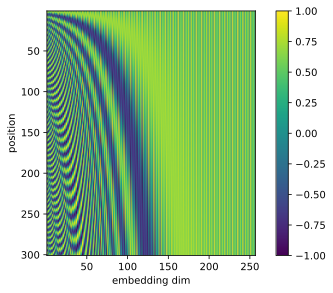

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
pos = ax.imshow(pe.numpy(), extent=(1, pe.shape[1] + 1, pe.shape[0] + 1, 1))
fig.colorbar(pos, ax=ax)
fig.tight_layout()
ax.set_xlabel("embedding dim")
ax.set_ylabel("position");

Observe that vertical lines at greater depth vary less than those at lower depth. This is because the frequency of the sine waves decrease with higher embedding depth. Hence, most of the positional embedding matrix is uninformative, i.e. later embedding dimensions is roughly constant (0 or 1) with respect to position. The logarithm-like curve is nice since this means the PE matrix tries as much as possible not to corrupt the original embedding weights. The individual PE vectors are visualized as follows:

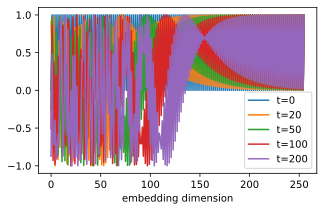

In [38]:
plt.figure(figsize=(5, 3))
for t in [0, 20, 50, 100, 200]:
    plt.plot(pe[t], label=f"t={t}")
plt.legend()
plt.xlabel("embedding dimension");

<br>

**Relative position.** Besides capturing absolute positional information, the above positional encoding also allows a model to easily learn to attend by relative positions. This is because for any fixed position offset $\Delta t$, the positional encoding $\boldsymbol{\mathsf{p}}_{t + \Delta t}$ at position $t + \Delta t$ can be represented as a linear projection of the position encoding $\boldsymbol{\mathsf{p}}_{t}$ at position $t.$ To see this, let $\omega_j = \omega^{{2j}/{d_\text{model}}}$ and recall the rotation transformation:

$$\begin{aligned}
\begin{bmatrix} \phantom{-} \cos(\Delta t \cdot \omega_j) & \sin(\Delta t \cdot \omega_j) \\  -\sin(\Delta t \cdot \omega_j) & \cos(\Delta t \cdot \omega_j) \\ \end{bmatrix}
\begin{bmatrix} \mathsf{p}_{t, 2j} \\  \mathsf{p}_{t, 2j+1} \\ \end{bmatrix}
=&\begin{bmatrix} \phantom{-} \cos(\Delta t \cdot \omega_j) \, \sin(t \cdot \omega_j) + \sin(\Delta t \cdot \omega_j) \, \cos(t \cdot \omega_j) \\  -\sin(\Delta t \cdot \omega_j) \, \sin(t \cdot \omega_j) + \cos(\Delta t \cdot \omega_j) \, \cos(t \cdot \omega_j) \\ \end{bmatrix}\\
=&\begin{bmatrix} \sin\left((t+\Delta t) \cdot \omega_j\right) \\  \cos\left((t+\Delta t) \cdot \omega_j\right) \\ \end{bmatrix}\\
=& 
\begin{bmatrix} \mathsf{p}_{i+\Delta t, 2j} \\  \mathsf{p}_{i+\Delta t, 2j+1} \\ \end{bmatrix}
\end{aligned}$$

where the $2\times 2$ projection matrix does not depend on any position index $t$. 
Note that we can build a full linear transformation of $\boldsymbol{\mathsf{P}}$ by using a block-diagonal matrix consisting of the above $2\times 2$ matrices. Since the MHA involves linear transformation of the input sequence, this might allow the model to easily attend to relative positions.

<br>

**Effect on attention.** Let us not look at how positional encodings are used in an actual attention model. One property we might want to have our position embeddings is that positions close to each other return large attention weights, while those far away return small ones. Of course, this is augmented by the actual keys and queries of the sequence vectors. But for raw PE vectors, this seems to be a good property to generally have.

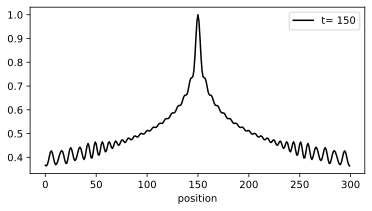

In [21]:
# normalized dot product with other PE vectors.
attn_score = (pe @ pe.T)[T // 2]
attn_score = attn_score / attn_score.max()
plt.figure(figsize=(6, 3))
plt.plot(attn_score, "k", label=f"t= {T // 2}")
plt.xlabel("position")
plt.legend();

This has to do with the [orthogonality](https://tutorial.math.lamar.edu/classes/de/PeriodicOrthogonal.aspx) of sine and cosine functions.

<br>

**Implementation.** Implementing the positional encoding module:

In [43]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        t = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)                        # (max_len, 1)
        w = torch.exp(-(torch.arange(0, d_model, 2).float() / d_model * math.log(10000)))   # (d_model,)
        pe[:, 0::2] = torch.sin(t * w)                                                      # (max_len, d_model)
        pe[:, 1::2] = torch.cos(t * w)                                                      # (max_len, d_model)
        pe = pe.unsqueeze(0)                                                                # (1, max_len, d_model)

        # https://discuss.pytorch.org/t/what-is-the-difference-between-register-buffer-and-register-parameter-of-nn-module/32723/8
        # tensor which is not a parameter, but should be part of module state
        # => register as a buffer => always same device as the module params
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]  # (B, T, d_model) + (1, T, d_model)
        return x

Testing:

In [44]:
x = torch.randn(32, 10, 512)
pe = PositionalEncoding(d_model=512)
print(pe.pe.shape)
print(pe(x).shape)

torch.Size([1, 5000, 512])
torch.Size([32, 10, 512])


<br>

**On maximum sequence length.** The MHA block works with sequences of arbitrary lengths even with fixed parameters. However, note that the positional encoding matrix grows linearly with the maximum allowed input length `max_len`. Since attention has a $O(T^2)$ memory requirement which constrains $T$ in practice, so defining a maximum length limit in advance is not limiting. This also means that we have to consider that we train with sequences of around the same lengths as the inference input as oftentimes there is a disconnect between training and inference environments.

## Transformer architecture

This section will explore the implementation of the MHA block in the **Transformer architecture** {cite}`transformers`. The Transformer architecture was originally designed for machine translation. Hence, it has an **encoder-decoder** structure where the encoder takes as input the sentence in the original language and generates an attention-based representation. Meanwhile, the decoder attends over the encoded information and generates the translated sentence in an [autoregressive manner](dl/04-lm). This structure is extremely useful for **Sequence-to-Sequence** tasks. Here we will focus on the encoder part. The decoder part is analogous and will be covered in a [future notebook](dl/08-translation).

```{figure} ../../img/nn/07-transformer.svg
---
name: 07-transformer
width: 450px
---
Transformer architecture {cite}`transformers`. [Source](https://www.d2l.ai/chapter_attention-mechanisms-and-transformers/transformer.html#model)
```

* encoder has N sequential blocks
* multi-head self-attention block
* residual connection after MHA x + LN(MHA(x, x, x)) following {cite}`transformer-tears`
* q, k, v = x at first
* residual connection comments
    - Similar to ResNets, Transformers are designed to be very deep. Some models contain more than 24 blocks in the encoder. Hence, the residual connections are crucial for enabling a smooth gradient flow through the model.
    - Without the residual connection, the information about the original sequence is lost. Note that the Multi-Head Attention layer ignores the position of elements in a sequence, and can only learn it based on the input features.
    - Removing the residual connections would mean that this information is lost after the first attention layer (after initialization), and with a randomly initialized query and key vector, the output vectors for position has no relation to its original input. All outputs of the attention are likely to represent similar/same information, and there is no chance for the model to distinguish which information came from which input element.
* LN comments:
    - enables faster training and provides small regularization. 
    - Additionally, ensures that the features are in a similar magnitude among the elements in the sequence. We are not using Batch Normalization because it depends on the batch size which is often small with Transformers (they require a lot of GPU memory), and BatchNorm has shown to perform particularly bad in language as the features of words tend to have a much higher variance (there are many, very rare words which need to be considered for a good distribution estimate).

* a small FFN is added Linear -> ReLU -> Linear. adds extra complexity. and allows transformations on each sequence element separately (?). post-process the new information added by the previous MHA and prepare it for the next attention block. usually width of MLP 2-8x larger than $d_\text{model}$ i.e. dimensionality of original embedding vector x. wider = faster parallelizable execution. 

* x + FFN(LN(x + MHA(LN(x), LN(x), LN(x)))) times N
* original: LN(x + FFN(LN(x + MHA(x, x, x)))) times N blocks

In [24]:
class EncoderBlock(nn.Module):

    def __init__(self, d_model, n_heads, ffn_width, dropout=0.0):
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(d_model, n_heads)

        # FFN: two-layer MLP
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ffn_width),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(ffn_width, d_model)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        x_ = self.norm1(x)
        attn_out = self.self_attn(x_, x_, x_, mask=mask)
        x = x + self.dropout(attn_out)

        # FFN part
        linear_out = self.ffn(self.norm2(x))
        x = x + self.dropout(linear_out)

        return x

Based on this block, we can implement a module for the full Transformer encoder. Additionally to a forward function that iterates through the sequence of encoder blocks, we also provide a function called get_attention_maps. The idea of this function is to return the attention probabilities for all Multi-Head Attention blocks in the encoder. This helps us in understanding, and in a sense, explaining the model. However, the attention probabilities should be interpreted with a grain of salt as it does not necessarily reflect the true interpretation of the model (there is a series of papers about this, including Attention is not Explanation and Attention is not not Explanation).

In [25]:
class TransformerEncoder(nn.Module):

    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps


**Remark.** Note that the attention layer is low-rank, it has at most rank $d.$ See previous notebook.

In [26]:
transformer = TransformerEncoder(3, d_model=32, n_heads=4, ffn_width=128)
transformer(torch.randn(8, 10, 32)).shape

torch.Size([8, 10, 32])

---

■